In [2]:
import dipole_module
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import joblib
import os
import time
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Choose a random seed to make things reproducible - can be varied later
random_seed = 42
np.random.seed(random_seed)

In [4]:
#This function reads in the dipole from file 'file' at x_Bjorken 'xbj'
#It uses Heikki's dipole amplitude code to extract the r dependent dipole
#at xbj doing the required interpolations
def read_dipole(file, xbj):
    try:
        if os.path.exists(file):  # Check if the file exists
            result = dipole_module.dipole_amplitude(file, xbj)
            lines = result.strip().split('\n')
        
            # Initialize c2_value
            c2_value = None

            # Read C2 from first line
            if lines and lines[0].startswith("#"):
                c2_value = float(lines[0].split()[1])

            # Remove the first line
            if lines:
                lines = lines[1:]
        
            data = [list(map(float, line.split())) for line in lines]
            result_array = np.array(data).T
        
            return result_array, c2_value
        else:
            print(f"File {file} does not exist.")
            return None, None  # Return None values if the file doesn't exist
    except Exception as e:
        print(f"An error occurred while processing {file} with xbj={xbj}: {e}")
        return None, None  # Return None values in case of an error

    
# Folder containing data files
data_folder = "data/training/"

# Dynamically list all files in the folder
file_names = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, file))]

# Number of files in the folder
max_files = len(file_names)

In [5]:
#Load data

#array of x values
exponent_values = np.linspace(-6, -2, 9)
x_values = 10.**(exponent_values)

#Initialize initial data array
initial_data = []

xdim = len(x_values)
print("Number of x values =",xdim)

target_data = []
  
max_files = len(file_names)#5000

for i in range(xdim):
    #Set target x value
    xbj_target = x_values[i]
    target_data_aux = []
    count = 0
    for file in tqdm(file_names, desc="Loading training and validation data", unit="file"):
        #print(file)
        #print("x value =",xbj_target)
        result_array, c2_value = read_dipole(file, xbj_target)
        if i == xdim-1:
            # Append c2_value to result_array[1]
            target_data_aux.append(result_array[1])
            new_result_array = np.append(result_array[1], c2_value)
            initial_data.append(new_result_array)
        else:
            target_data_aux.append(result_array[1])
        count = count + 1
        if count >= max_files:
            break
    target_data.append(np.array(target_data_aux))
   
            
input_values = np.vstack(initial_data)
r = result_array[0]
print(len(target_data))

Number of x values = 9


Loading training and validation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24529/24530 [01:53<00:00, 215.76file/s]

9


0
1e-06
Dimensions = 10
102
Mean Squared Error (Ensemble): 0.00010422452836358918
R-squared (Ensemble): 0.8837740380359043


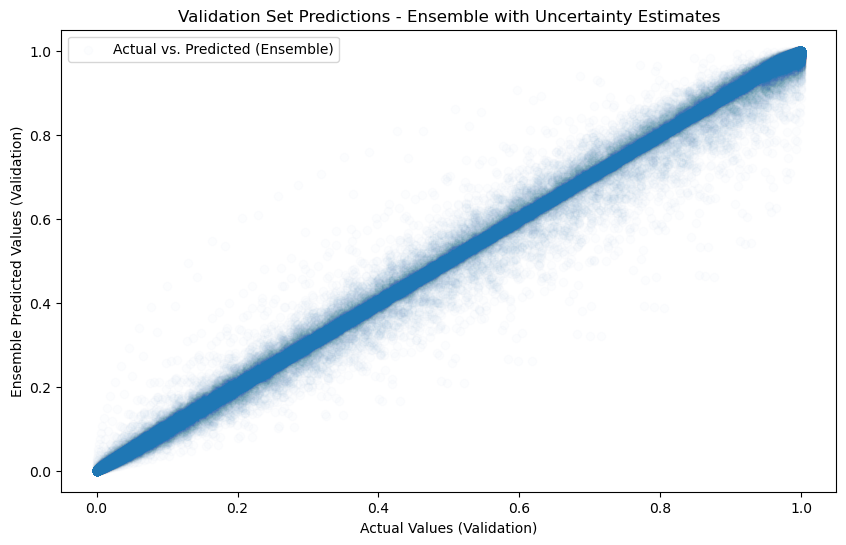

1
3.162277660168379e-06
Dimensions = 10
102
Mean Squared Error (Ensemble): 0.00010084474684999061
R-squared (Ensemble): 0.8903421084424432


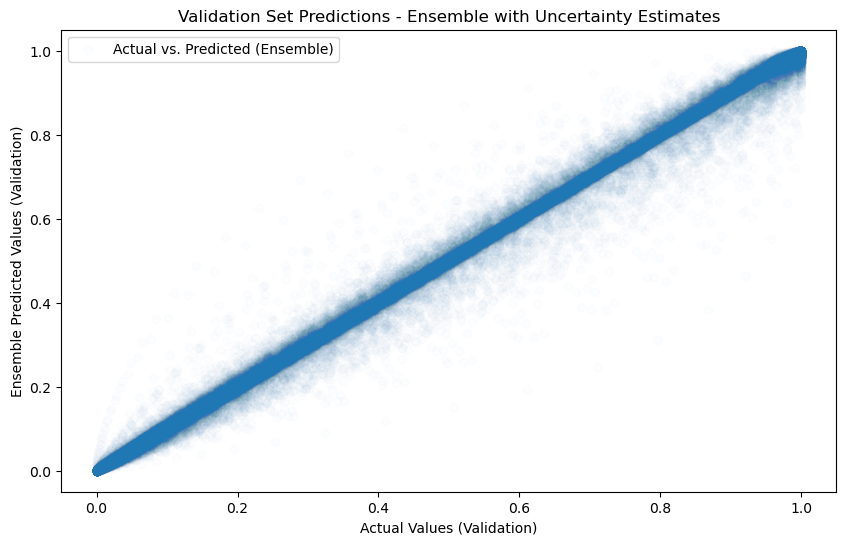

2
1e-05
Dimensions = 10
102
Mean Squared Error (Ensemble): 0.00010063776705185996
R-squared (Ensemble): 0.8788075042508747


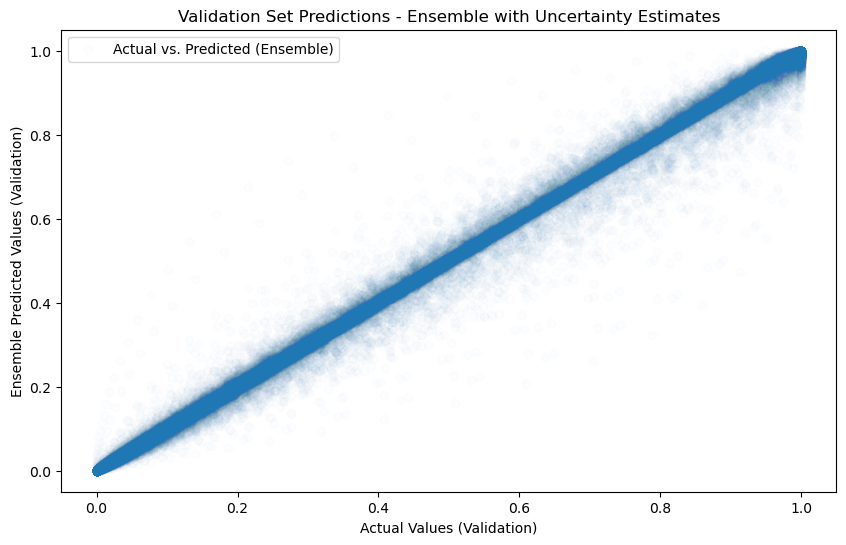

3
3.1622776601683795e-05
Dimensions = 10
102
Mean Squared Error (Ensemble): 9.669516486831938e-05
R-squared (Ensemble): 0.8725388990492137


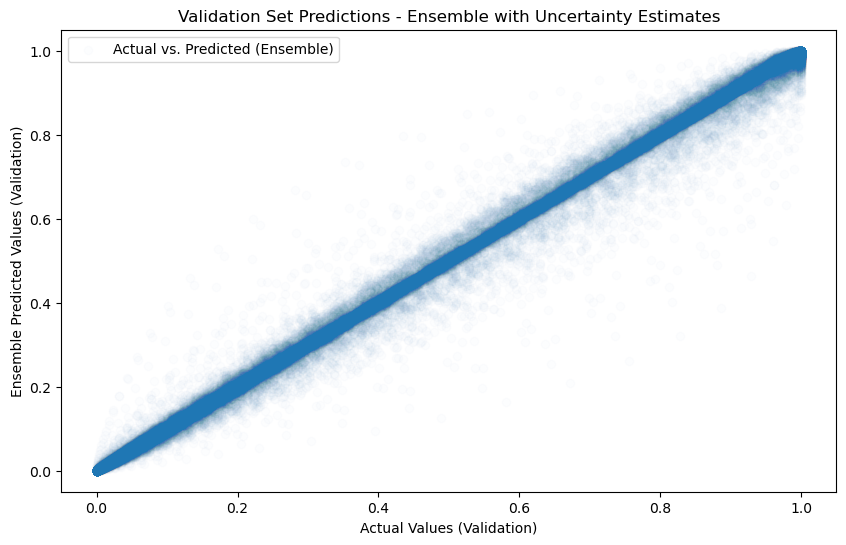

4
0.0001
Dimensions = 10
102
Mean Squared Error (Ensemble): 9.054614882993215e-05
R-squared (Ensemble): 0.8889476871971138


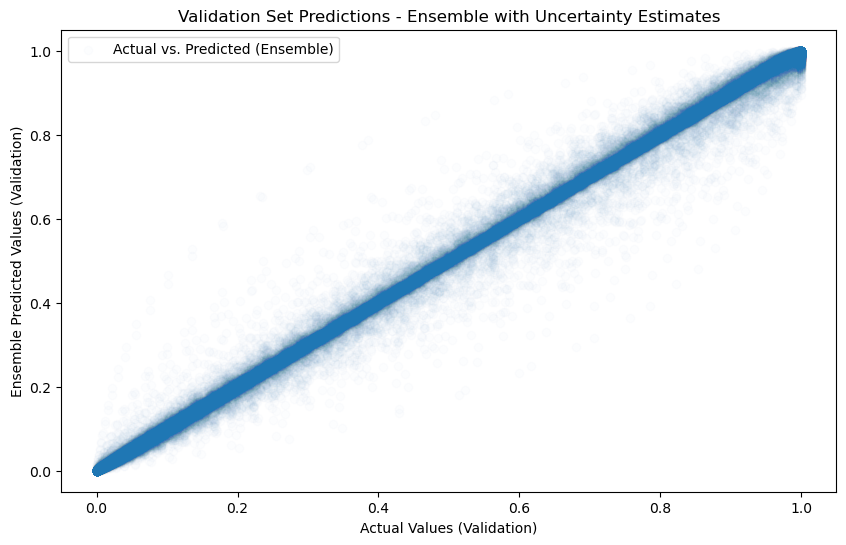

5
0.00031622776601683794
Dimensions = 10
102
Mean Squared Error (Ensemble): 7.65992677438397e-05
R-squared (Ensemble): 0.9330168815701781


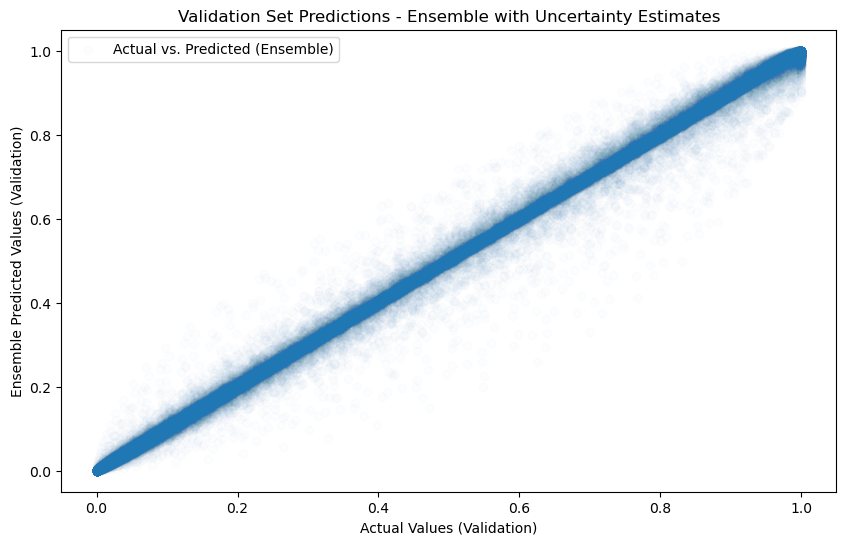

6
0.001
Dimensions = 10
102
Mean Squared Error (Ensemble): 9.23026621973427e-05
R-squared (Ensemble): 0.9288871972690823


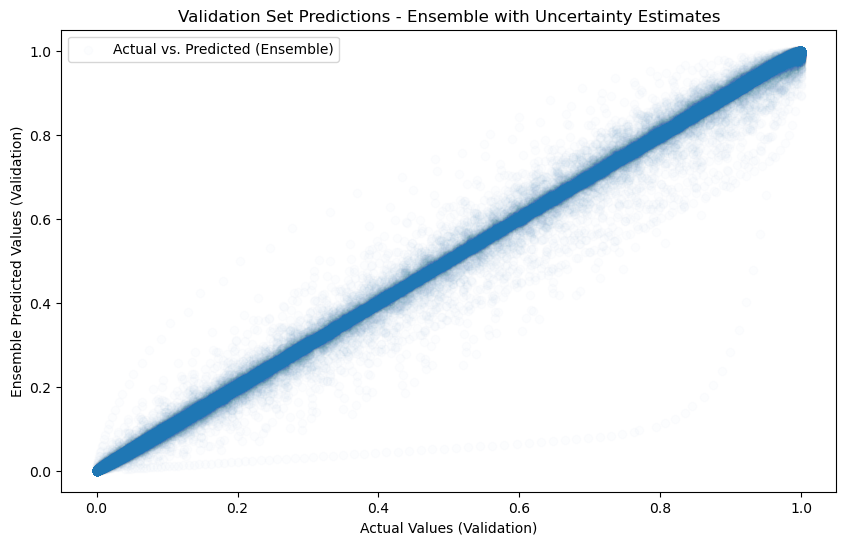

7
0.0031622776601683794
Dimensions = 10
102
Mean Squared Error (Ensemble): 4.160988761727707e-05
R-squared (Ensemble): 0.9664462024029744


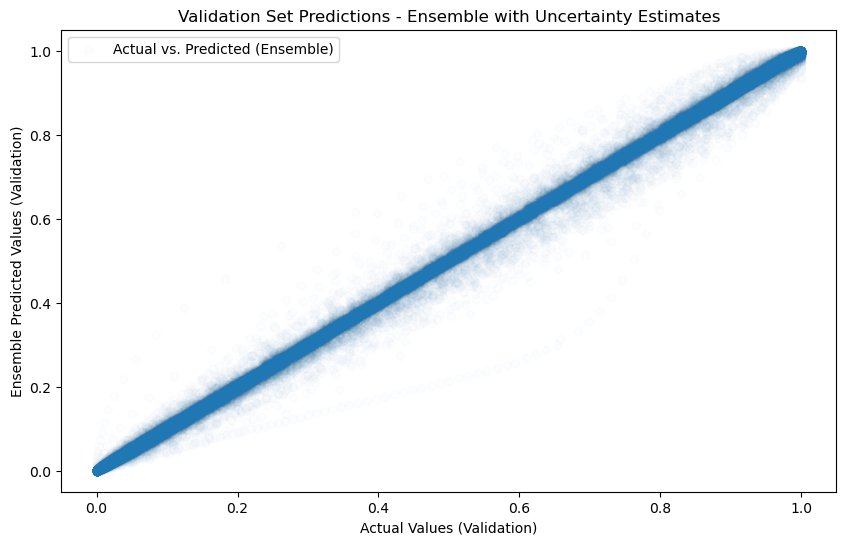

8
0.01
Dimensions = 10
102
Mean Squared Error (Ensemble): 1.1406174124385347e-05
R-squared (Ensemble): 0.9905125039280002


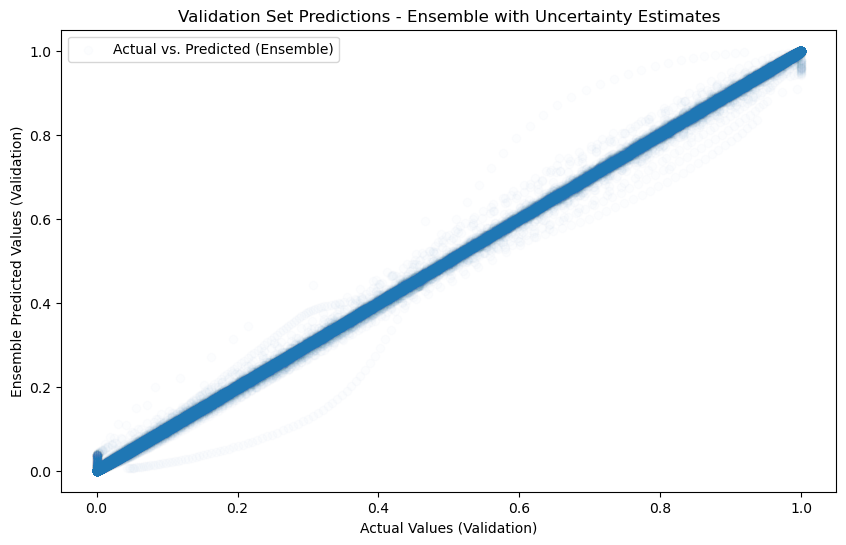

In [28]:
#Train Random Forest
#Loop over x values

#Initialize array to hold models at different x
RF_models = []
PCA_models = []
Scalers = []

#Number of principal components for PCA
n_components = 10

X_val_list = []
y_val_list = []

for i in range(xdim):
    print(i)
    print(x_values[i])
    
    #Set the output values to be at the desired x
    output_values = np.vstack(target_data[i])
        
    input_dim = input_values.shape[1]
    print("Dimensions =",n_components)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(input_values, output_values, test_size=0.2, random_state=42)
    
    #Save true data for later in a list for different x
    X_val_list.append(X_val)
    y_val_list.append(y_val)
    
    print(len(X_train[0]))
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_val_standardized = scaler.transform(X_val)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_standardized)
    X_val_pca = pca.transform(X_val_standardized)

    # Define and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_components, max_depth = 12, min_samples_leaf=1, random_state=42)
    rf_model.fit(X_train_pca, y_train)

    # Make predictions on the validation set
    y_val_pred_rf = rf_model.predict(X_val_pca)
    
    # Obtain uncertainty estimates (variance) across trees
    y_val_pred_all_trees = np.stack([tree.predict(X_val_pca) for tree in rf_model.estimators_], axis=0)
    y_val_pred_variance = np.var(y_val_pred_all_trees, axis=0)

    # Evaluate performance on the validation set
    mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)
    r2_val_rf = r2_score(y_val, y_val_pred_rf)

    print(f'Mean Squared Error (Ensemble): {mse_val_rf}')
    print(f'R-squared (Ensemble): {r2_val_rf}')

    # Visualization with uncertainty estimates
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred_rf, alpha=0.01, label='Actual vs. Predicted (Ensemble)')

    plt.xlabel('Actual Values (Validation)')
    plt.ylabel('Ensemble Predicted Values (Validation)')
    plt.title('Validation Set Predictions - Ensemble with Uncertainty Estimates')
    plt.legend()
    plt.show()

    #Append the model for this target x value to the list of models
    Scalers.append(scaler)
    PCA_models.append(pca)
    RF_models.append(rf_model)

In [29]:
# Save scaler and model to a file
filename_scaler = 'scaler-xList-full.joblib'
filename_pca = 'pca_model-xList-full.joblib'
filename_models = 'rcBK-RF-xList-full.joblib'

joblib.dump(Scalers, filename_scaler)
joblib.dump(PCA_models,filename_pca)
joblib.dump(RF_models, filename_models, compress = 1)

['rcBK-RF-xList-full.joblib']

58 0.0012406863067328455
C^2= 82.6623


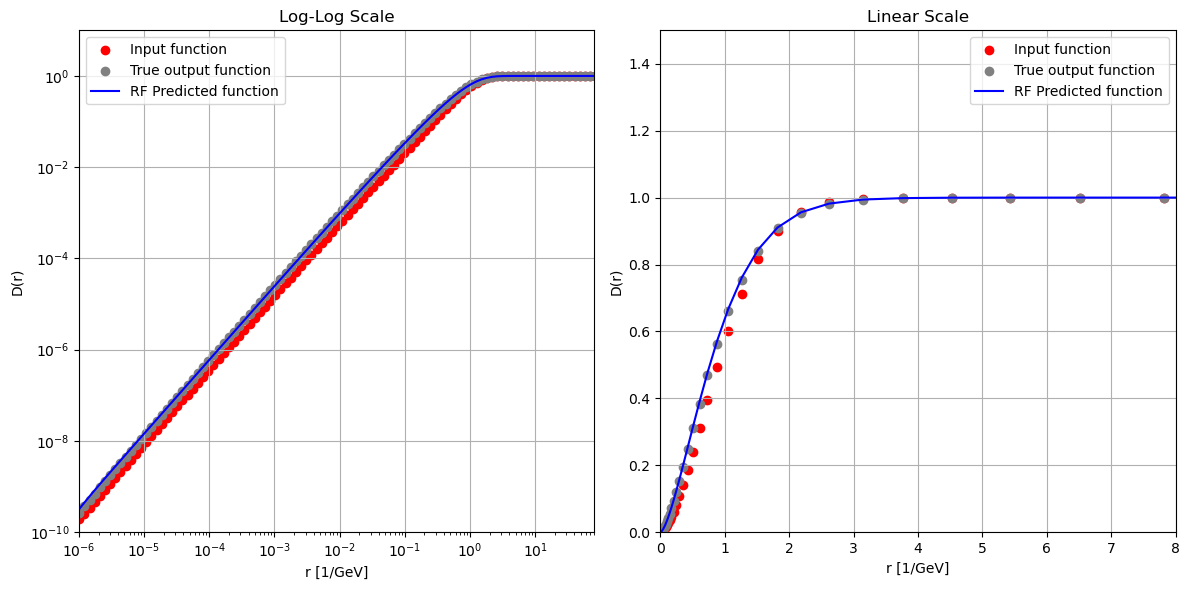

In [32]:
# Define the range in log space
log_lower_bound = np.log(1e-6)
log_upper_bound = np.log(0.01)

# Sample a value logarithmically
log_sample = np.random.uniform(log_lower_bound, log_upper_bound)

# Convert the log value to the original scale
x = np.exp(log_sample)
x_values_arr = np.array(x_values)

i = np.random.randint(0, 100)

print(i, x)

print("C^2=",X_val[i][101])

insert_index = np.searchsorted(x_values_arr, x)
adjacent_values = x_values_arr[max(0, insert_index - 1):insert_index + 1]

imp = [insert_index - 1, insert_index]
frac = (adjacent_values[1]-x)/(adjacent_values[1]-adjacent_values[0])

true_values = (1.-frac)*y_val_list[imp[1]][i] + (frac)*y_val_list[imp[0]][i]

# Standardize the data
scaler = Scalers[imp[0]]
X_val_standardized_0 = scaler.transform([X_val_list[imp[0]][i]])
scaler = Scalers[imp[1]]
X_val_standardized_1 = scaler.transform([X_val_list[imp[0]][i]])

# Apply PCA to reduce dimensionality
pca = PCA_models[imp[0]]
X_val_pca_0 = pca.transform(X_val_standardized_0)
pca = PCA_models[imp[1]]
X_val_pca_1 = pca.transform(X_val_standardized_1)

#Predict on the fly:
predicted_output_values = [RF_models[imp[0]].predict(X_val_pca_0)[0], RF_models[imp[1]].predict(X_val_pca_1)[0]]

output_values = (1.-frac)*predicted_output_values[1] + (frac)*predicted_output_values[0]

# Plot with log-log scale
plt.figure(figsize=(12, 6))

# Plot with log-log scale
plt.subplot(1, 2, 1)
plt.xlim(0.000001, 80.) 
plt.ylim(1e-10, 10.) 
plt.scatter(r, X_val[i][:101], color='red', label='Input function')
plt.scatter(r, true_values, color='gray', label='True output function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True)

# Plot with linear scale
plt.subplot(1, 2, 2)
plt.xlim(0, 8.) 
plt.ylim(0, 1.5) 
plt.scatter(r, X_val[i][:101], color='red', label='Input function')
plt.scatter(r, true_values, color='gray', label='True output function')
plt.plot(r, output_values, color='blue', label='RF Predicted function')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Linear Scale')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
